In [1]:
import numpy as np
from IPython import display  # used for clearing plots, to view during the simulation
# https://github.com/JolleJolles/SwarmKit/blob/master/run_simulation.ipynb
        
def ptwsimulation(simmodel, showprogress=False, simulator='ptw'):
    numparticles, beta, mu_s, tau_turn, tau_speed, sigma_speed, sigma_turn, socialweight = simmodel.numparticles, simmodel.beta, simmodel.mu_s, simmodel.tau_turn, simmodel.tau_speed, simmodel.sigma_speed, simmodel.sigma_turn, simmodel.socialweight
    mean_mu_s = simmodel.mean_mu_s
    
    numstates, stopgosim, statespeedmult, Tswitch, stopgosocial, sigma_stopgo = simmodel.numstates, simmodel.stopgosim, simmodel.statespeedmult, simmodel.Tswitch, simmodel.stopgosocial, simmodel.sigma_stopgo

    numsimsteps, usevectorcalc, savestep, dt, xsize, ysize, numsavesteps = simmodel.numsimsteps, simmodel.usevectorcalc, simmodel.savestep, simmodel.dt, simmodel.xsize, simmodel.ysize, simmodel.numsavesteps
    speedsocialweight = simmodel.speedsocialweight
    


    
    allparticles = np.zeros([numsavesteps, numparticles, 9])

    [startxpositions,startypositions]=[xsize*np.random.rand(numparticles),ysize*np.random.rand(numparticles)];
    startangles=2*np.pi*np.random.rand(numparticles)-np.pi;
    startspeeds=mu_s*np.ones([numparticles])

    startparticles = np.transpose([startxpositions, # x
                                   startypositions, # y
                                   startspeeds*np.cos(startangles), # vx
                                   startspeeds*np.sin(startangles), # vy
                                   startspeeds, # speed
                                   startangles, # orientation
                                   np.zeros([numparticles]), # angular velocity
                                   np.random.rand(numparticles), # stop-go accumulator variable
                                   np.random.randint(numstates,size=numparticles)  # 'state'
                                   ]);
    allparticles[0]=startparticles;

    # for optimizing running times and making code easier:
    ind_x, ind_y, ind_vx, ind_vy, ind_spd, ind_ang, ind_angvel, ind_stopgo, ind_state = np.arange(9)
    lnp = np.arange(numparticles)

    currentparticles=startparticles

    # this makes it so that the last entry of "allparticles" won't be zeros, if savestep evenly divides numsimsteps
    if savestep==1:
        numrun = numsimsteps
    else:
        numrun = numsimsteps+1

    step = 1
    ss = 0

    while ss<numsavesteps:
        
        # social interactions via zonal model
        diff=simmodel.getdiffs(currentparticles) 
        cmdirs, cmspeed = simmodel.getModelDirections(diff,currentparticles[:,ind_ang])

        # ignore social interactions if within the range to ignore:
        if (step>simmodel.ignoresteps[0]) & (np.mod(step,simmodel.ignoresteps[1])-simmodel.ignoresteps[0]<0):
            cmdirs = 0*cmdirs

        vxhat, vyhat = [np.cos(currentparticles[:,ind_ang]), np.sin(currentparticles[:,ind_ang])]  

        if simulator=='ptw':
            socialtorque = socialweight*(vxhat*cmdirs[:,1]-vyhat*cmdirs[:,0])
            # scale torque with speed
            betavals=beta_fn(currentparticles[:,ind_spd]/1,beta)  # leave mu_s here, i.e. don't make it zero
            # updates for angular velocity, orientation, speed
            angvel = currentparticles[:,ind_angvel] + dt/tau_turn*(betavals*socialtorque - currentparticles[:,ind_angvel]) + sigma_turn*np.sqrt(dt)*betavals*np.random.randn(numparticles)

        else:
            if simulator=='classiczonal':  # then use the "classic" Couzin model, where you specify the angle
                # check if the angle is too large
                zonalangle = np.arctan2(cmdirs[:,1],cmdirs[:,0])
                deltaangle = normAngle(zonalangle-currentparticles[:,ind_ang])

            elif simulator=='persistantzonal':  # then use the updated version from Ionnou, where there is persistance in preferred direction
                # do this calculation with vectors, because that is how the paper did it
                desired_vx = simmodel.p_turn_self*vxhat + (1-simmodel.p_turn_self)*cmdirs[:,0]
                desired_vy = simmodel.p_turn_self*vyhat + (1-simmodel.p_turn_self)*cmdirs[:,1]            
                zonalangle = np.arctan2(desired_vy,desired_vx)
                deltaangle = normAngle(zonalangle-currentparticles[:,ind_ang])

            clip = np.abs(deltaangle)>simmodel.maxturnangle
            deltaangle[clip] = np.sign(deltaangle[clip])*(simmodel.maxturnangle)[clip]
            #  add noise.  # the 3/2 comes from stepping the angle, instead of angular velocity
            deltaangle += sigma_turn*(dt**(3/2))*np.random.randn(numparticles)
            angvel = deltaangle/dt

            # so that they "find" each other, give ptw dynamics if social==zero
            notusingsocial = np.logical_not( (cmdirs[:,1]**2+cmdirs[:,0]**2) > 0 )
            angvel[notusingsocial] = currentparticles[notusingsocial,ind_angvel] + sigma_turn*np.sqrt(dt)*np.random.randn(np.sum(notusingsocial))


        # if is over.  do these below for all of the cases
        angle = normAngle(currentparticles[:,ind_ang] + dt*angvel)

        if simmodel.strictdirection==True:
            angle[0]=0
            angvel[0]=0
        
        # stop-go state matches
        if stopgosim:
            currentstates = (currentparticles[:,ind_state]).astype(int)
            statematches = np.array([s==currentstates for s in currentstates])*2-1  # +1 for match, -1 for not match
            insocialzone = diff[:,:,2]<simmodel.r_attract
            stateslope = np.array([(np.sum(st[z])-1)/np.sum(z) for st, z in zip(statematches,insocialzone)])
    #         stateslope = (np.sum(statematches,axis=1)-1)/(numparticles-1)  # mean after substract the state of self.  This has the mean going over all space, not just the social zone though
            stopgoaccum = currentparticles[:,ind_stopgo] + dt/Tswitch[lnp,currentstates]*(1-stopgosocial*stateslope) + sigma_stopgo*np.sqrt(dt)*np.random.randn(numparticles)
            stopgoaccum = np.maximum(stopgoaccum,0)
            # see if ones have crossed the threshold.  for these, reset them and switch the states
            toswitch = stopgoaccum>=1
            stopgoaccum[toswitch]=0
            states=currentstates.copy()   # new states
            states[toswitch] = np.mod(states[toswitch]+1,numstates)  # this 'cycles though' states, and could allow for more than 2 states
        else:
            currentstates = np.zeros(numparticles).astype(int)
            states = np.zeros(numparticles).astype(int)
            stopgoaccum = np.zeros(numparticles)

        speed = (currentparticles[:,ind_spd] + dt/tau_speed*(mu_s*statespeedmult[lnp,currentstates] + speedsocialweight*cmspeed - currentparticles[:,ind_spd]) 
                 + statespeedmult[lnp,currentstates]*sigma_speed*np.sqrt(dt)*np.random.randn(numparticles)/np.sqrt(tau_speed))
        speed = np.maximum(speed,0)

        # update the velocity
        vx = speed*np.cos(angle)
        vy = speed*np.sin(angle)
        xpos=np.mod(currentparticles[:,ind_x] + dt*vx,xsize)
        ypos=np.mod(currentparticles[:,ind_y] + dt*vy,ysize)
        newparticles = np.stack((xpos,ypos,vx,vy,speed,angle,angvel,stopgoaccum,states),axis=1)    

        # save for this step, if a savestep
        if np.mod(step,savestep)==0:
            allparticles[ss] = newparticles     

        currentparticles=newparticles        

        if np.mod(step,2000)==0:
            if showprogress:
                display.clear_output(wait=True)  
                print(step,numsimsteps)

        step = step+1
        ss=np.floor_divide(step,savestep)

    return allparticles



## calculate quantities for analysis
def dist_and_dcoords(allparticles,simmodel,showprogress=False):
    numsavesteps, numparticles, _ = allparticles.shape
    alldist = np.zeros([numsavesteps,numparticles,numparticles])
    alldcoords = np.zeros([numsavesteps,numparticles,numparticles,2])
    alldcoords_rotated = np.zeros([numsavesteps,numparticles,numparticles,2])
    ind_x, ind_y, ind_vx, ind_vy, ind_spd, ind_ang, ind_angvel = np.arange(7)
    def getmin(vals):
        return np.min(np.reshape(vals,(numparticles,numparticles,-1)),axis=2)
    for ss in range(numsavesteps):
        if np.mod(ss,2000)==0:
            if showprogress:
                display.clear_output(wait=True) 
                print(ss,numsavesteps)
        diff = simmodel.getdiffs(allparticles[ss])    
        dists=np.reshape(diff[:,:,2],(numparticles,numparticles,-1))
        alldist[ss] = np.min(dists,axis=2) 
        am = np.argmin(dists,axis=2) 
        # I can't think of a better way to do this, to reshape the arrays using vectors.  I tried for awhile... so, here, just have loops over j, which isn't needed, but does the job
        dx = np.reshape(diff[:,:,0],(numparticles,numparticles,-1))
        dy = np.reshape(diff[:,:,1],(numparticles,numparticles,-1))
        for i in range(numparticles):
            xrot = np.cos(-allparticles[ss,i,ind_ang])
            yrot = np.sin(-allparticles[ss,i,ind_ang])
            for j in range(numparticles):
                alldcoords[ss,i,j] = [ dx[i,j,am[i,j]] , dy[i,j,am[i,j]]]
            alldcoords_rotated[ss,i] = np.dot([[xrot,-yrot],[yrot,xrot]],alldcoords[ss,i].T).T
    return alldist, alldcoords_rotated

def beta_fn(spd_mu, beta,a=1):
    if beta==1:
        return np.ones(len(spd_mu))
    else:
        return a*np.power(beta,1-np.abs(spd_mu))
   
def normAngle(angles):
    return np.arctan2(np.sin(angles),np.cos(angles))

In [2]:
import numpy as np
import torch as torch


class simmodel:
    def __init__(self,numparticles,numsteps,savestep=15):
        self.numparticles = numparticles
        self.beta = 1 # scaling to decrease turning amplitude with speed.  beta=1 means no change
        self.mu_s = np.ones(numparticles)

        self.tau_turn = np.ones(numparticles)*0.1
        self.tau_speed = np.ones(numparticles)
        self.sigma_speed = 0.2 # 0.2 was used in paper
        self.sigma_turn = 3 # 
        self.socialweight = 0.5  # 2 is approx the same as Ioaunnou model, but its too high for this - they always stay together then
        self.speedsocialweight = 0  # this defaults to zero
        self.mean_mu_s = 1  # should be 1.  This is used for setting the size of the repulsion, align, attract zones
        self.r_repulsion = 3.657*self.mean_mu_s
        self.r_align = 6.857*self.mean_mu_s
        self.r_attract = 20*self.mean_mu_s
        self.ignoresteps=[200,10**4]  # [how many steps to ignore social, how often to do it]
        self.maxturnangle = 10*(np.pi/180)
        self.p_turn_self = 0  # used for persistantzonal.  Persistantzonal with p_turn_self=0 is the same as classic zonal.  if p_turn_seflf=1, then will ignore social
        self.viewingzone=np.pi

        self.strictdirection = False

        # Stop-go parameters
        self.stopgosim=False
        self.numstates=2  # [go, stop]
        self.Tswitch = 10*np.ones((numparticles,self.numstates))
        self.statespeedmult = np.ones((numparticles,self.numstates))
        self.statespeedmult[:,1] = 0.2
        self.stopgosocial = 0.8
        self.sigma_stopgo=0.1        

        # Configuration
        self.numsimsteps=numsteps  #really, should do at least 10**6, probably more, to ensure sampling enough
        self.usevectorcalc = False
        self.savestep=savestep  # don't save all the simulation results - only save this many timesteps
        self.dt = 1/10
        self.xsize, self.ysize = [60,60]
        self.numsavesteps=np.floor(self.numsimsteps/self.savestep).astype(int)    
        self.periodic=True        


        # wall interaction functions, when use
        self.LJ_epsilon = 1/100; #amplitude
        self.LJ_sigma = .05 # distance
        self.LJ_wallcutoff=np.power(2,1/6)*self.LJ_sigma # keep only repulsive part of the LJ wall force
        self.wallturn_epsilon = 1/100;  # amplitude for wall turning epsilon
        self.wallturn_sigma = 0.05;  # distance for wall turning        
        
    def update_mean_mu_s(self,mean_mu_s):
        self.mean_mu_s = mean_mu_s  # should be 1.  This is used for setting the size of the repulsion, align, attract zones
        self.r_repulsion = 3.657*self.mean_mu_s
        self.r_align = 6.857*self.mean_mu_s
        self.r_attract = 20*self.mean_mu_s

    def getdiffs(self,ptcls):
        if (not self.periodic):
            print('Use periodic boundaries!  I will finish the boundary simulations later')
            return
        #  Now can assume that boundaries are periodic
        if self.usevectorcalc:
            return vectordiffs_periodic(ptcls,self.xsize,self.ysize)
        else:       
            return loopdiffs_periodic(ptcls,self.xsize,self.ysize)

    def getModelDirections(self,diff,angles):
        if self.speedsocialweight==0:  # then use the regular verion, without speed social changes
            cmspeed = np.zeros(self.numparticles)
            if self.usevectorcalc:
                if self.r_attract==self.r_align:
                    cmdirs = getCouzinModelDir_vector_torch(diff,angles,self.r_repulsion,self.r_align,self.viewingzone)
                else:
                    print('Vector calc is only written to work with single social zone')
                    return
            else:
                # not vector calc
                cmdirs = np.array([getCouzinModelDir(d,a,self.r_repulsion,self.r_align,self.r_attract,self.viewingzone) for d,a in zip(diff,angles)])
        else:  # use version with speed changes
            if self.usevectorcalc:
                print('Vector calc does not work with speed changes')
            else:
                cm=np.array([getCouzinModelDirSpeed(d,a,self.r_repulsion,self.r_align,self.r_attract,self.viewingzone) for d,a in zip(diff,angles)])
                cmdirs = cm[:,0:2]
                cmspeed = cm[:,2]                     
        return cmdirs, cmspeed


########################################################################################################################################
#### Distance functions
########################################################################################################################################
def vectordiffs_periodic(ptcls,xsize,ysize):
    # Use torch to do vector calculation distance, but just on the cpu
    numparticles = len(ptcls)
    positions = ptcls[:, 0:2]

    result = np.empty([numparticles, numparticles, 5])
    
    #create shifted positions
    # note that this will get the case wrong where a particle is simultaneously outside of "both" periodic boundaries.  But this is very rare and therefore should not be problem
    posup = np.copy(positions)
    posdown = np.copy(positions)
    posleft = np.copy(positions)
    posright = np.copy(positions)
    posleft[:,0] = posleft[:,0] - xsize
    posright[:,0] = posright[:,0] + xsize
    posup[:, 1] = posup[:, 1] + ysize
    posdown[:, 1] = posdown[:, 1] - ysize
    allpos = np.vstack(np.vstack([[positions], [posleft], [posright], [posup], [posdown]]).swapaxes(0,1))    
    #allpos = np.vstack((positions, posleft, posright, posup, posdown )) 

    #converts all numpy to tensors
    allpositions = torch.from_numpy(allpos)
    pos = torch.from_numpy(positions)

    #distance based calculations
    expanded_x1 = torch.unsqueeze(pos, 0)  
    expanded_x2 = torch.unsqueeze(allpositions, 1)
    #Distance between every pair of particles in x in every dimension (dx,dy)
    rx = expanded_x2 - expanded_x1
    diffs = rx
    # square distane for each particle pair in each dimension  (dx^2,dx^2)
    rx2 = rx.type(torch.FloatTensor) ** 2
    # absolute square distance between every pair of particles(dx^2+dx^2)
    r2 = torch.sum(rx2, 2)
    # absolute distance between every pair of particles
    dists = torch.sqrt(r2)

    #convert dists and diffs back into numpy 
    dists = dists.numpy()
    diffs = diffs.numpy()


    #creates velocity matrix
    velocity = ptcls[:, 2:4]
    vel = torch.from_numpy(velocity)
    expanded_v1 = torch.unsqueeze(vel, 0)  
    expanded_v2 = torch.unsqueeze(vel, 1)
    dv = expanded_v2 - expanded_v1
    vdiffs = dv.numpy()
    vdiffs = np.vstack(np.vstack([[vdiffs], [vdiffs], [vdiffs], [vdiffs], [vdiffs]]).swapaxes(0,1))   
    dvx = vdiffs[:, :, 0]
    dvy = vdiffs[:, :, 1]
    
    #masks and reshapes position difference and dist matrices 
    diffx=diffs[:,:,0]
    diffy=diffs[:,:,1]
    
    # make infinite distance for the particle with itself
#    lnp = np.arange(numparticles)
#    dists[lnp*5,lnp]=np.inf
    
    #concatenates and returns results as one array
#     result = np.concatenate((diffx, diffy, dists, vx, vy), 1)
    result= np.concatenate([[diffx],[diffy],[dists],[dvx],[dvy]],axis=0).T
    return result            

def loopdiffs_periodic(ptcls,xsize,ysize):
    numparticles=len(ptcls)
    pos=ptcls[:,0:2];
    vel=ptcls[:,2:4];
    result=np.empty([numparticles,numparticles,5]);
    for focus in range(numparticles):
        # get difference correct it for periodic boundaries
        diffs=pos-pos[focus];
        for q in range(numparticles):
            diffs[q]=correctdiff(diffs[q],xsize,ysize)
        # calculate distances
        dists=Vlen_array(diffs)
        # calculate velocity vector difference
        vdiffs=vel-vel[focus];
        # save the results
        result[focus]=np.concatenate((diffs,np.transpose([dists]),vdiffs),axis=1);        
        # returns:  [diff_x, diff_y, dist, diff_vx, diff_vy]
        #           [  0   ,   1   ,   2 ,   3,       4
    return result         
# helper function to correct for periodic boundaries, not using vector calc    
def correctdiff(dd,xsize,ysize): # Corrects the distance calculation for the periodic box size
    newdd=dd;
    if dd[0]<(-xsize/2): 
        newdd[0]=newdd[0]+xsize
    elif dd[0]>=(xsize/2): 
        newdd[0]=newdd[0]-xsize
    if dd[1]<(-ysize/2): 
        newdd[1]=newdd[1]+ysize
    elif dd[1]>=(ysize/2): 
        newdd[1]=newdd[1]-ysize      
    return newdd

########################################################################################################################################
# Model functions, to get zonal desired direction
########################################################################################################################################
def getCouzinModelDir(neighbors,focusangle, r_r, r_o, r_a, viewingzone):
    mixsocialzone = (r_a==r_o)
    repdir=np.array([0,0]);
    numrep=0;
    aligndir=np.array([0,0]);
    attractdir=np.array([0,0]);
    for nnum in range(len(neighbors)):
        # get the zone, and add to direction correction
        viewingangle=(focusangle-np.arctan2(neighbors[nnum,1],neighbors[nnum,0]))
        ndist=neighbors[nnum,2]
        if (np.cos(viewingangle)>np.cos(viewingzone)) & (ndist>0):
            if ndist<=r_r:
                #zone=1
                numrep=numrep+1
                repdir = repdir - neighbors[nnum,0:2]/ndist
            else:
                if ndist<=r_o:
                    #zone=2
                    # usee the difference in velocities, not the absolute velocity of the neighbor
                    aligndir = aligndir + neighbors[nnum,3:5]/Vlen(neighbors[nnum,3:5])
                        #zone=3
                if mixsocialzone:  # then just have a single "social" zone
                    if ndist<=r_a:
                        attractdir = attractdir + neighbors[nnum,0:2]/ndist
                else:
                    if (ndist<=r_a) & (ndist>r_o):
                        attractdir = attractdir + neighbors[nnum,0:2]/ndist
    # use the zonal directions to determine the new direction
    newdir=np.array([0,0]);
    if numrep>0:
        newdir = repdir;
    else:
        newdir = aligndir + attractdir;
    vlennewdir=Vlen(newdir);
    if vlennewdir>0:  # only normalize if >0, to avoid div by zero errors.  Also, it will return zero length vector, if no neighbors
        newdir=newdir/vlennewdir; 
    return newdir

def getCouzinModelDirSpeed(neighbors,focusangle,r_r, r_o, r_a, viewingzone,speedweights=[1,1]):
    mixsocialzone = (r_a==r_o)
    repdir=np.array([0,0]);
    numrep=0;
    aligndir=np.array([0,0]);
    attractdir=np.array([0,0]);
    repspeed = 0
    socialspeed = 0
    
    # rotated coordinates of neighbors:
    xrot = np.cos(-focusangle)
    yrot = np.sin(-focusangle)
    coords_rotated =np.dot([[xrot,-yrot],[yrot,xrot]],neighbors[:,0:2].T).T
    for nnum in range(len(neighbors)):
        # get the zone, and add to direction correction
        viewingangle=(focusangle-np.arctan2(neighbors[nnum,1],neighbors[nnum,0]))
        ndist=neighbors[nnum,2]
        
        if (np.cos(viewingangle)>np.cos(viewingzone)) & (ndist>0):
            if ndist<=r_r:
                #zone=1
                numrep=numrep+1
                repdir = repdir - neighbors[nnum,0:2]/ndist
                repspeed = repspeed - coords_rotated[nnum,0]
            else:
                dxrot = np.abs(coords_rotated[nnum,0])  # get abs value                
                if ndist<=r_o:  #zone=2
                    # use the difference in velocities, not the abs velocity of the neighbor
                    aligndir = aligndir + neighbors[nnum,3:5]/Vlen(neighbors[nnum,3:5])

                if mixsocialzone:  # then just have a single "social" zone
                    if ndist<=r_a:
                        attractdir = attractdir + neighbors[nnum,0:2]/ndist
                        if (dxrot>r_r) & (dxrot<=r_a):  # make speed changes if in 'social zone'
                            socialspeed = socialspeed + coords_rotated[nnum,0]                  
                else:
                    if (ndist<=r_a) & (ndist>r_o):
                        attractdir = attractdir + neighbors[nnum,0:2]/ndist
                        if (dxrot<=r_a) & (dxrot>r_o):  # make speed changes if in attract zone
                            socialspeed = socialspeed + coords_rotated[nnum,0]                                          
    # use the zonal directions to determine the new direction
    newdir=np.array([0,0]);
    dspeed = 0
    if numrep>0:
        newdir = repdir;
        dspeed = speedweights[0]*np.sign(repspeed)
    else:
        newdir = aligndir + attractdir;
        dspeed = speedweights[1]*np.sign(socialspeed)
    vlennewdir=Vlen(newdir);
    if vlennewdir>0:  # only normalize if >0, to avoid div by zero errors
        newdir=newdir/vlennewdir;    
    return np.append(newdir, dspeed)


def getCouzinModelDir_vector_torch(diff,angles,r_r,r_s,viewingzone):
    # this is a partially optimized way to calculate the desired direction.  It is "partially optimized", because some of the things below could probably be better - the baseline performance is about the same as the naiive cpu implementation.  However, with this, the scaling with larger number of neighbors is much better - adding a larger social zone (and therefore more neighbors), does not change the running time, whereas it does significantly for the regular version
    ntorch = torch.from_numpy(diff)
    viewtest = torch.from_numpy(np.cos([viewingzone]))
    anglestorch = torch.from_numpy(angles[:,None])

    if viewingzone < np.pi:
        viewneighbors = torch.cos(anglestorch-torch.atan2(ntorch[:,:,1],ntorch[:,:,0])) > viewtest
    else:
        viewneighbors = torch.ones(diff.shape[0:2])
        viewneighbors = viewneighbors.type(torch.uint8)

    # this wasn't any faster.
#     calc = torch.cos(anglestorch-torch.atan2(ntorch[:,:,1],ntorch[:,:,0]))
#     viewneighbors = calc.ge(viewtest)    

    repzone = viewneighbors & (ntorch[:,:,2]<= r_r) & (ntorch[:,:,2]>0) 
    socialzone = viewneighbors & (np.logical_not(repzone)) & (ntorch[:,:,2]<=r_s) & (ntorch[:,:,2]>0)

    userep = torch.sum(repzone,1)>0
    usesocial = np.logical_not(userep) & (torch.sum(socialzone,1)>0)
    
    repzonedouble = repzone.type(torch.DoubleTensor)
    socialzonedouble = socialzone.type(torch.DoubleTensor)
    
    xrep = ntorch[:,:,0]*repzonedouble
    yrep = ntorch[:,:,1]*repzonedouble
    distrep = ntorch[:,:,2][repzone]
    xrep[repzone] = xrep[repzone]/distrep
    yrep[repzone] = yrep[repzone]/distrep
    rx = - torch.sum(xrep,1)
    ry = - torch.sum(yrep,1)
    rx = rx[userep]
    ry = ry[userep]
    rnorm = torch.sqrt(rx**2+ry**2)
    rx, ry = rx/rnorm, ry/rnorm
    
    xsoc = ntorch[:,:,0]*socialzonedouble
    ysoc = ntorch[:,:,1]*socialzonedouble
    distsoc = ntorch[:,:,2][socialzone]  
    xsoc[socialzone] = xsoc[socialzone]/distsoc
    ysoc[socialzone] = ysoc[socialzone]/distsoc
    ax, ay = torch.sum(xsoc,1), torch.sum(ysoc,1)
    ax = ax[usesocial]
    ay = ay[usesocial]
    
    vxsoc = ntorch[:,:,3]*socialzonedouble
    vysoc = ntorch[:,:,4]*socialzonedouble
    vnorm = torch.sqrt(vxsoc[socialzone]**2+vysoc[socialzone]**2)
    vxsoc[socialzone] = vxsoc[socialzone]/vnorm
    vysoc[socialzone] = vysoc[socialzone]/vnorm
    ox, oy = torch.sum(vxsoc,1), torch.sum(vysoc,1)
    ox = ox[usesocial]
    oy = oy[usesocial]
    sx, sy = ax+ox, ay+oy
    snorm = torch.sqrt(sx**2+sy**2)
    sx = sx/snorm
    sy = sy/snorm
    
    newdirs = torch.zeros((len(diff),2))
    newdirs = newdirs.type(torch.DoubleTensor)
    newdirs[userep,0] = rx
    newdirs[userep,1] = ry
    newdirs[usesocial,0] = sx
    newdirs[usesocial,1] = sy    
    
    return newdirs.data.numpy()

########################################################################################################################################
# misc functions, used above to help with calculations
########################################################################################################################################

def fixanglerange(angles): # Puts all angles into a range of [-Pi,Pi] 
    return np.arctan2(np.sin(angles),np.cos(angles))
    
def Vlen(vec):  # vector length
    return np.sqrt(vec[0]*vec[0]+vec[1]*vec[1]) 

def Vlen_array(vecarray):
    return np.sqrt(vecarray[:,0]**2+vecarray[:,1]**2)
        



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# for calculating social interactions
# import functions.PTWsimulation as ptw
# import functions.modelfunctions as mf
 
snscolors=sns.color_palette()

In [4]:
# Run single simulation
# Define parameters and simulation setup

In [5]:
# define parameters
numparticles=10
numsteps = 1 * 10**4


model = simmodel(numparticles,numsteps,)  
model.dt = 0.1
model.savestep=5  # save the results this many steps
model.numsavesteps = np.floor(model.numsimsteps/model.savestep).astype(int) 
model.sigma_speed = 0.2  # this should be sigma_speed/sqrt(tau_speed)

# these should have the length of the number of particles
model.socialweight = np.tile(0.5,numparticles)
model.sigma_turn = 3*np.ones(numparticles)  # note that this should be sigma/sqrt(tau_turn)
model.mu_s = np.ones(numparticles)  # the mean should be 1


# -----

# stop-go added
model.stopgosim=True
# model.Tswitch = np.array([[10,10],[40,10]])
model.stopgosocial = 0.8
# should have dimensions of [N individuals, N_states]
model.statespeedmult = np.array([np.ones(numparticles),0.2/np.array(model.mu_s)]).T  # [individual,states]   # speed multipliers for the states, to modify mu


# simulator can be:  ['ptw','classiczonal','persistantzonal']
whichsim = 'ptw'

# vars(model)

In [8]:
 # run simulation
start = time.time()
allparticles = ptwsimulation(model,showprogress=True,simulator=whichsim)
# get metrices for analyzing results
alldist, alldcoords_rotated = dist_and_dcoords(allparticles,model)

time.time()-start

# alldcoords_rotated

8000 10000


14.940080165863037

In [9]:
allparticles

array([[[ 2.12176769e+01,  1.66418165e+01, -9.52011727e-01, ...,
          0.00000000e+00,  3.97851427e-01,  0.00000000e+00],
        [ 2.98136139e+01,  5.17564682e+01, -8.04746044e-01, ...,
          0.00000000e+00,  4.34224179e-01,  0.00000000e+00],
        [ 3.30571241e+01,  3.87518555e+01, -9.67476295e-01, ...,
          0.00000000e+00,  9.48625291e-01,  1.00000000e+00],
        ...,
        [ 3.90566190e+01,  1.78581708e+01,  4.72923520e-01, ...,
          0.00000000e+00,  8.54062201e-01,  0.00000000e+00],
        [ 3.90129565e+01,  1.93272766e+01,  4.77397657e-01, ...,
          0.00000000e+00,  1.52882651e-01,  0.00000000e+00],
        [ 4.75234456e+01,  1.12232866e+01,  6.06643023e-01, ...,
          0.00000000e+00,  9.47087731e-01,  0.00000000e+00]],

       [[ 2.07662373e+01,  1.63472539e+01, -7.69984263e-01, ...,
          1.07591168e+00,  5.99146804e-01,  0.00000000e+00],
        [ 2.94096722e+01,  5.14233040e+01, -8.56048757e-01, ...,
         -3.09763880e-01,  3.97456273e

In [9]:


# Plots of results
# the numpy array 'allparticles' contains results stored as: [timestep, particle, quantity] The different quantities are: x, y, vx, vy, spd, ang, angvel, stopgo, state

In [10]:
# 
# allparticles

# model.numparticles

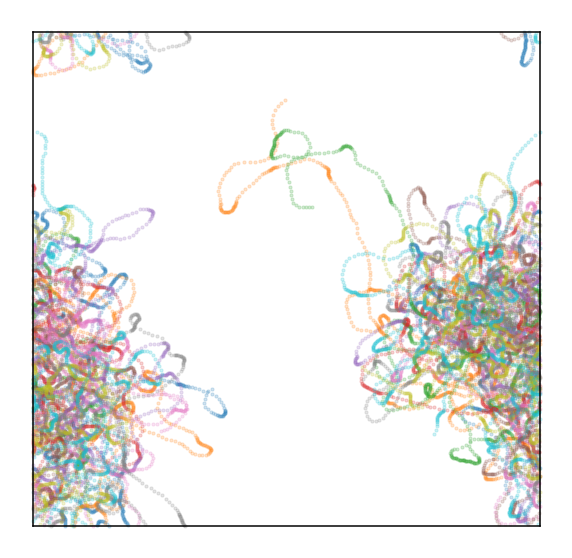

In [10]:
# to make code below easier
numparticles = model.numparticles
xsize, ysize, savestep, dt = model.xsize, model.ysize, model.savestep, model.dt
ind_x, ind_y, ind_vx, ind_vy, ind_spd, ind_ang, ind_angvel, ind_stopgo, ind_state = np.arange(9)
wallsegments=np.array([ [[0,0],[xsize,0]], [[xsize,0],[xsize,ysize]], [[xsize,ysize],[0,ysize]], [[0,ysize],[0,0]] ])
showlen=np.floor(100/savestep).astype(int)

# plot the whole simulated trajectories
f,ax = plt.subplots(1,1)
f.set_size_inches(10,10)
for k in range(len(wallsegments)):
    ax.plot(wallsegments[k,:,0],wallsegments[k,:,1],'k')  
ax.axis('off')
for i in range(numparticles):
    ax.scatter(allparticles[:,i,0],allparticles[:,i,1],color=snscolors[i],alpha=0.2,s=10)

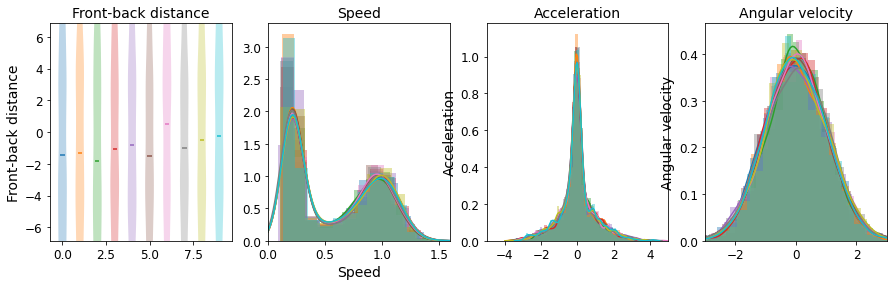

In [11]:
# plots:  front-back dist, speed, ang vel
f, ax = plt.subplots(1,4)
f.set_size_inches(15,4)
# front-back distance
for focus in range(numparticles):
    sel = np.delete(np.arange(numparticles),focus)
    c = alldcoords_rotated[:,focus,sel,0]
    d = alldist[:,focus,sel]
    tp =  - c[d < model.r_attract]  # note the negative sign:  here, plotting which is more of a "leader"
    if len(tp)>0:
        ax[0].violinplot(tp,positions=[focus],showmedians=True,showextrema=False)
    else:
        print('front-back distance:  zero data points')
ax[0].set_ylabel('Front-back distance',fontsize=14)
ax[0].set_title('Front-back distance',fontsize=14)
ax[0].set_ylim([-model.r_align,model.r_align])

# speed
a=ax[1]
[sns.distplot(allparticles[:,focus,ind_spd],ax=ax[1],hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_xlabel('Speed',fontsize=14)
a.set_title('Speed',fontsize=14)
# a.set_ylim([0,2])
a.set_xlim([0,1.6])

# acceleration
a=ax[2]
[sns.distplot(np.gradient(allparticles[:,focus,ind_spd])/dt,ax=a,hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_ylabel('Acceleration',fontsize=14)
a.set_title('Acceleration',fontsize=14)
a.set_xlim([-5,5])

# angvel
a=ax[3]
avmax=10
[sns.distplot(allparticles[:,focus,ind_angvel][np.abs(allparticles[:,focus,ind_angvel])<=avmax],ax=a,hist=True) for focus in range(numparticles)]  # by doing it in a loop instead of at once, it shows different colors
a.set_xlim([-3,3])
a.set_ylabel('Angular velocity',fontsize=14)
a.set_title('Angular velocity',fontsize=14)

# format
# [a.set_xticks(np.arange(numparticles)) for a in ax]
# [a.set_xlabel('Fish',fontsize=14) for a in ax]
[a.tick_params(labelsize=12) for a in ax]
plt.show()






In [2]:
# allparticles.dtype.names
allparticles.shape

# the numpy array 'allparticles' contains results stored as: 
# [timestep, particle, quantity] 
# The different quantities are: x, y, vx, vy, spd, ang, angvel, stopgo, state

# Show me the last columns of all animals
allparticles[:,:,-1].tolist()

NameError: name 'allparticles' is not defined

In [20]:
import numpy

# numpy.savetxt("/Users/diegoellis/Desktop/Virtual_stickleback.csv", allparticles, delimiter=",")


with open('/Users/diegoellis/Desktop/stickleback_boids.tsv', 'w') as out:
  for timestep, time in enumerate(allparticles):
    for particle, bird in enumerate(time):
      x, y, vx, vy, spd, ang, angvel, stopgo, state = bird
      out.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(timestep, particle, x, y, vx, vy, spd, ang, angvel, stopgo, state))


In [215]:
# To make the code compatible with doub we need to only obtain  longitude and latitude (not speed or angular velocity)
allparticles.shape

# Dimensions are as follows: Timepoints, number of animals, 2D (Longitude, Latitude)
newparticles = allparticles[:,:, :2]




np.save('/Users/diegoellis/Desktop/fish_flock-simulation', newparticles)


newparticles.shape

newparticles

array([[[42.14683503,  7.84026361],
        [34.71080047, 52.61279749],
        [42.91631292, 35.2540255 ],
        ...,
        [15.39718421, 18.61237715],
        [ 4.14054372, 16.22033972],
        [46.76706256, 59.88381318]],

       [[42.14483466,  7.45827454],
        [34.98720255, 52.33599446],
        [42.75354503, 34.89787585],
        ...,
        [15.23539033, 18.94831508],
        [ 4.66777212, 16.32122869],
        [46.78936861, 59.47473489]],

       [[42.16523351,  7.21094184],
        [35.21055691, 52.19203386],
        [42.67980234, 34.63170468],
        ...,
        [15.04185479, 19.10071622],
        [ 5.12518296, 16.47286871],
        [46.83825614, 58.96938288]],

       ...,

       [[49.60397492,  1.3785958 ],
        [50.90578967, 59.80176611],
        [43.9789461 , 49.81032857],
        ...,
        [47.76086498, 55.75346119],
        [50.22847971, 54.04358725],
        [44.33317169, 55.85583309]],

       [[49.61610002,  1.49111308],
        [50.8061289 , 59.78

In [220]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import threading
import pygame
import random
import mido
import math
import os
import rtmidi

class Boid:
  '''Boid class from https://github.com/rougier/from-python-to-numpy/blob/master/code/boid_python.py'''
  def __init__(self, x, y):
    self.acceleration = vec2(0, 0)
    angle = random.uniform(0, 2*math.pi)
    self.velocity = vec2(math.cos(angle), math.sin(angle))
    self.position = vec2(x, y)
    self.r = 2.0
    self.max_velocity = 2
    self.max_acceleration = 0.03
  
  def seek(self, target):
    desired = target - self.position
    desired = desired.normalized()
    desired *= self.max_velocity
    steer = desired - self.velocity
    steer = steer.limited(self.max_acceleration)
    return steer
  
  # Wraparound
  def borders(self):
    x, y = self.position
    x = (x+self.width) % self.width
    y = (y+self.height) % self.height
    self.position = vec2(x,y)
  
  # Separation: Method checks for nearby boids and steers away
  def separate(self, boids):
    desired_separation = 25.0
    steer = vec2(0, 0)
    count = 0
    # For every boid in the system, check if it's too close
    for other in boids:
      d = (self.position - other.position).length()
      # If the distance is > 0 and < an arbitrary amount (0 when you are yourself)
      if 0 < d < desired_separation:
        # Calculate vector pointing away from neighbor
        diff = self.position - other.position
        diff = diff.normalized()
        steer += diff/d  # Weight by distance
        count += 1     # Keep track of how many
    # Average - divide by how many
    if count > 0:
      steer /= count
    # As long as the vector is greater than 0
    if steer.length() > 0:
      # Implement Reynolds: Steering = Desired - Velocity
      steer = steer.normalized()
      steer *= self.max_velocity
      steer -= self.velocity
      steer = steer.limited(self.max_acceleration)
    return steer
  
  # Alignment: For every nearby boid in the system, calculate the average velocity
  def align(self, boids):
    neighbor_dist = 50
    sum = vec2(0, 0)
    count = 0
    for other in boids:
      d = (self.position - other.position).length()
      if 0 < d < neighbor_dist:
        sum += other.velocity
        count += 1
    if count > 0:
      sum /= count
      # Implement Reynolds: Steering = Desired - Velocity
      sum = sum.normalized()
      sum *= self.max_velocity
      steer = sum - self.velocity
      steer = steer.limited(self.max_acceleration)
      return steer
    else:
      return vec2(0, 0)
  
  # Cohesion: For the average position (i.e. center) of all nearby boids, calculate
  # steering vector towards that position
  def cohesion(self, boids):
    neighbor_dist = 50
    sum = vec2(0, 0)  # Start with empty vector to accumulate all positions
    count = 0
    for other in boids:
      d = (self.position - other.position).length()
      if 0 < d < neighbor_dist:
        sum += other.position  # Add position
        count += 1
    if count > 0:
      sum /= count
      return self.seek(sum)
    else:
      return vec2(0, 0)
  
  def flock(self, boids):
    sep = self.separate(boids)  # Separation
    ali = self.align(boids)     # Alignment
    coh = self.cohesion(boids)  # Cohesion
    # Arbitrarily weight these forces
    sep *= 1.5
    ali *= 1.0
    coh *= 1.0
    # Add the force vectors to acceleration
    self.acceleration += sep
    self.acceleration += ali
    self.acceleration += coh
  
  def update(self):
    # Update velocity
    self.velocity += self.acceleration
    # Limit speed
    self.velocity = self.velocity.limited(self.max_velocity)
    self.position += self.velocity
    # Reset acceleration to 0 each cycle
    self.acceleration = vec2(0, 0)
  
  def run(self, boids):
    self.flock(boids)
    self.update()
    self.borders()

class Flock:
  def __init__(self, count=150, width=640, height=360):
    self.width = width
    self.height = height
    self.boids = []
    for i in range(count):
      boid = Boid(width/2, height/2)
      boid.width = width
      boid.height = height
      self.boids.append(boid)
  
  def run(self):
    for boid in self.boids:
      boid.run(self.boids)
  
  def cohesion(self, boids):
    P = np.zeros((len(boids),2))
    for i, boid in enumerate(self.boids):
      P[i] = boid.cohesion(self.boids)
    return P
##
# Helpers
##

def struct(name, members):
  cls = namedtuple(name, members)
  cls.__repr__ = lambda self: "%s(%s)" % (name, ','.join(str(s) for s in self))
  return cls

class vec2(struct('vec2', ('x', 'y'))):
  def __add__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x+other.x, self.y+other.y)
    return vec2(self.x+other, self.y+other)
  
  def __sub__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x-other.x, self.y-other.y)
    return vec2(self.x-other, self.y-other)
  
  def __mul__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x*other.x, self.y*other.y)
    return vec2(self.x*other, self.y*other)
  
  def __truediv__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x/other.x, self.y/other.y)
    return vec2(self.x/other, self.y/other)
  
  def length(self):
    return math.hypot(self.x, self.y)
  
  def normalized(self):
    length = self.length()
    if not length:
      length = 1.0
    return vec2(self.x/length, self.y/length)
  
  def limited(self, maxlength=1.0):
    length = self.length()
    if length > maxlength:
      return vec2(maxlength*self.x/length, maxlength*self.y/length)
    return self

##
# Midi
##

def play_midi(arg):
  '''Stream `arg` (midi file path or mido.midifile)'''
  tmp = None
  if isinstance(arg, mido.midifiles.midifiles.MidiFile):
    tmp = 'temp-{}.mid'.format(random.randint(0, 2**64))
    arg.save(tmp)
    path = tmp
  else:
    path = arg
  # play the audio
  freq = 44100     # audio CD quality
  bitsize = -16    # unsigned 16 bit
  channels = 2     # 1 is mono, 2 is stereo
  n_samples = 1024 # number of samples
  pygame.mixer.init(freq, bitsize, channels, n_samples)
  pygame.mixer.music.set_volume(0.8) # optional volume 0 to 1.0
  # play the clip
  try:
    clock = pygame.time.Clock()
    pygame.mixer.music.load(path)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
      clock.tick(30) # check if playback has finished
  except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
  if tmp: os.remove(tmp)
  return arg

##
# Config
##

n = 50 # number of boids
flock = Flock(n) # boid Flock
P = np.zeros((n,2)) # positions in one frame
l = [] # positions across all frames
domains = {'x': [0, 640], 'y': [0, 360]} # domains to use in x, y dimensions]
domains = {'x': [0, 90], 'y': [0, 90]} # domains to use in x, y dimensions]
# dapted to the bounding box of the fish {'x': [0.0021039866791150476, 0.00046673428754218094],
#  'y': [59.9994011835847, 59.99844871886264]}


# domains = {'x': [
  # np.min(flock_arr [:,:,0]), 
  # np.min(flock_arr [:,:,1]), 
# ], 'y': [
 # np.max(flock_arr [:,:,0]), 
 # np.max(flock_arr [:,:,1]), 
# ]}

domains

{'x': [0, 90], 'y': [0, 90]}

In [221]:
import random
import numpy as np

# identify available pitch steps within chromatic scale
base_steps = [0, 2, 4, 5, 7, 9, 11]
steps = []
for octave in [3,4,5]:
  steps += [i+(octave*12) for i in base_steps]

# identify the number of distinct pitches in each dimension
n_x_stops = 10
n_y_stops = 10

# quantize out a grid
x_stops = np.linspace(domains['x'][0], domains['x'][1], num=n_x_stops, endpoint=False)
y_stops = np.linspace(domains['y'][0], domains['y'][1], num=n_y_stops, endpoint=False)

# create the coordinate grid
coord_grid = np.array(np.meshgrid(x_stops, y_stops)).T

# create the grid of pitch steps
pitch_grid = np.zeros((n_x_stops, n_y_stops))
kdx = 0
for idx, i in enumerate(pitch_grid):
  for jdx, j in enumerate(i):
    pitch_grid[idx, jdx] = steps[kdx]
    kdx = kdx+1
    if kdx >= len(steps): kdx = 0
pitch_grid = pitch_grid.astype('int')

In [222]:
# steps indicates the full list of notes that can be played in this pitch grid
print(steps)

[36, 38, 40, 41, 43, 45, 47, 48, 50, 52, 53, 55, 57, 59, 60, 62, 64, 65, 67, 69, 71]


In [223]:
# display the full pitch grid
pitch_grid

array([[36, 38, 40, 41, 43, 45, 47, 48, 50, 52],
       [53, 55, 57, 59, 60, 62, 64, 65, 67, 69],
       [71, 36, 38, 40, 41, 43, 45, 47, 48, 50],
       [52, 53, 55, 57, 59, 60, 62, 64, 65, 67],
       [69, 71, 36, 38, 40, 41, 43, 45, 47, 48],
       [50, 52, 53, 55, 57, 59, 60, 62, 64, 65],
       [67, 69, 71, 36, 38, 40, 41, 43, 45, 47],
       [48, 50, 52, 53, 55, 57, 59, 60, 62, 64],
       [65, 67, 69, 71, 36, 38, 40, 41, 43, 45],
       [47, 48, 50, 52, 53, 55, 57, 59, 60, 62]])

In [224]:
newparticles = newparticles[:,:,:2]
flock_arr = newparticles


#domains = {'x': [
 # np.min(flock_arr [:,:,0]), 
  #np.min(flock_arr [:,:,1]), 
#], 'y': [
 # np.max(flock_arr [:,:,0]), 
 # np.max(flock_arr [:,:,1]), 
# ]}

domains
# Create a domain:

# domain = min(flock_arr['x']), min(flock_arr['y'])


# Crea te a domain -> dynamicaslly base don bounding box
# save the animation

# Redefine the pitch grid based on the domain !!!!! 



# boid_animation.save('boid-animation.mp4', fps=20)


{'x': [0, 90], 'y': [0, 90]}

In [225]:
from sklearn.cluster import KMeans
from collections import defaultdict

m = mido.MidiFile()
m.tracks.append(mido.MidiTrack())

step = 1 # how often to sample frames
time_scalar = 1200 # beats per unit in i
times = {i: 0 for i in steps} # d[note] = time the note was pressed
pressed = {i: False for i in steps} # d[note] = pressed or not
positions = [] # [[list of x,y positions in pitch space for frame]]

# store all times in absolute coords
# flock_arr = np.load('/Users/diegoellis/flocking/flock-simulation.npy')


flock_arr = np.load('/Users/diegoellis/Desktop/fish_flock-simulation.npy')



for idx, i in enumerate(flock_arr): # time
  if idx % step != 0: continue
  model = KMeans(n_clusters=3).fit(i)
  frame_centroids = model.cluster_centers_
  # convert the k flock centroid positions to notes
  frame_notes = []
  frame_positions = []
  for x, y in frame_centroids:
    # find the index offsets of x, y in the coords grid
    x_pos = np.where(x_stops < x)[0][-1]
    y_pos = np.where(y_stops < y)[0][-1]
    # get the pitch that corresponds with the centroid
    # FOr each time get xy for each centroid and append that to a pitch grid. 
    # 
    frame_notes.append( pitch_grid[x_pos, y_pos] )
    frame_positions.append([x_pos, y_pos])
  positions.append(frame_positions)
  # end each played note that's not in the new notes
  for note in pressed:
    if not pressed[note]: continue
    if note not in frame_notes:
      m.tracks[0].append( mido.Message('note_off', note=note, time=idx*time_scalar) )
      pressed[note] = False
  # add the new notes
  for note in frame_notes:
    if not pressed[note]:
      pressed[note] = True
      times[note] = idx
      m.tracks[0].append( mido.Message('note_on', note=note, time=idx*time_scalar) )
# close all open notes
for note in pressed:
  if not pressed[note]: continue
  m.tracks[0].append( mido.Message('note_off', note=note, time=idx*time_scalar) )
      # Midi has note on off concept, press a certain note of the keyboard at a certain time and the note off releases the key
# convert times to relative offsets
# press. a note 
last_time = 0
for i in m.tracks[0]: 
  t = i.time
  i.time = i.time - last_time

last_time = t

In [227]:

m.tracks[0].insert(0, mido.MetaMessage('set_tempo', tempo=990))
m.ticks_per_beat = 300

In [228]:
# set tempo and save

# if False:
m.tracks[0].insert(0, mido.MetaMessage('set_tempo', tempo=990))
m.ticks_per_beat = 300
m.save('/Users/diegoellis/Desktop/fish_flock.mid')



In [233]:
os.system('open /Users/diegoellis/Desktop/fish_flock.mid')
  
# convert to mp3
# if os.path.exists('flock.mp3'): os.remove('flock.mp3')
os.system('timidity /Users/diegoellis/Desktop/fish_flock.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k /Users/diegoellis/Desktop/fish_flock.mp3')

0

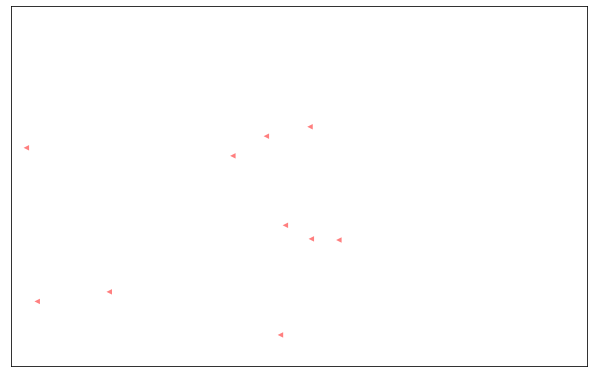

In [229]:
# visualize the raw sequence - one point per boid
def update(time):
  scatter.set_offsets(flock_arr[time])

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=True)
scatter = ax.scatter(P[:,0], P[:,1], s=30, facecolor='red', edgecolor='None', alpha=0.5, marker='<')

# interval = time between frames in milliseconds
boid_animation = FuncAnimation(fig, update, interval=30, frames=len(flock_arr))
ax.set_xlim(*domains['x'])
ax.set_ylim(*domains['y'])
ax.set_xticks([])
ax.set_yticks([])

# save the animation
boid_animation.save('/Users/diegoellis/Desktop/fish_boid-animation.mp4', fps=20)
HTML(boid_animation.to_html5_video())



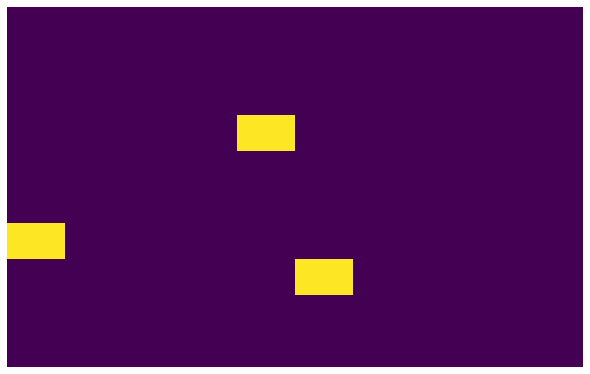

In [230]:
# HTML(boid_animation.to_html5_video())

def get_frame_array(frame_idx):
  f = np.zeros((n_x_stops, n_y_stops))
  for x,y in p[frame_idx]: 
    f[n_y_stops-y-1, x] = 1 # set the centroid boxes to 1, invert y axis
  return f

def update(i):
  im.set_array(get_frame_array(i))

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False, xticks=[], yticks=[])

p = np.array(positions)
im = ax.imshow(get_frame_array(0))

# interval = time between frames in milliseconds
centroid_animation = FuncAnimation(fig, update, interval=30, frames=len(positions))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('auto')

# save the animation
centroid_animation.save('/Users/diegoellis/Desktop/fish_centroid-animation.mp4', fps=20)

HTML(centroid_animation.to_html5_video())



In [234]:


# Stack Animations

os.system('ffmpeg -y -i /Users/diegoellis/Desktop/fish_boid-animation.mp4 -i /Users/diegoellis/Desktop/fish_centroid-animation.mp4 -filter_complex "[1:v][0:v]scale2ref[ua][b];[ua]setsar=1,format=yuva444p,colorchannelmixer=aa=0.5[u];[b][u]overlay=eof_action=pass[v]" -map [v] /Users/diegoellis/Desktop/fish_stacked-animation.mp4')



0

In [235]:
# Combine animations with audio

# Add the audio to the stacked animations

import subprocess

def get_file_duration(filename):
  result = subprocess.check_output('ffprobe -show_entries format=duration -i {}'.format(filename), shell=True)
  seconds = float(str(result).split('duration=')[1].split('\\n')[0])
  return seconds
  
audio_seconds = get_file_duration('/Users/diegoellis/Desktop/fish_flock.mp3')
video_seconds = get_file_duration('/Users/diegoellis/flocking/stacked-animation.mp4')

# stretch the video duration
ratio = audio_seconds / video_seconds
os.system('ffmpeg -i /Users/diegoellis/Desktop/fish_stacked-animation.mp4 -filter_complex "setpts=PTS*{}" /Users/diegoellis/Desktop/fish_stretched.mp4'.format(ratio))

# combine the audio and video
os.system('ffmpeg -i /Users/diegoellis/Desktop/fish_flock.mp3 -i /Users/diegoellis/Desktop/fish_stretched.mp4 /Users/diegoellis/Desktop/combined.mp4')



0

In [237]:
# Generate GIF

# Command to convert mp4 files to gif

os.system('ffmpeg -ss 30 -t 10 -i /Users/diegoellis/Desktop/fish_boid-animation.mp4 -vf "fps=20,scale=640:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 /Users/diegoellis/Desktop/fish_output.gif')

256